# Analyze Boston's Airbnb dataset
## The dataset describe the airbnb's listings activity in Boston it includes 3 separate files:
### Calendar: including listing id and the price and availability for that day
### Listings: including full descriptions and average review score
### Reviews: including unique id for each reviewer and detailed comments
### Data source: https://www.kaggle.com/airbnb/boston

## In this notebook we try to explore and better understand airbnb listings in Boston.
## We mainly target to answer 3 main questions:
#### **What is the average availability by season? Does the price change by season?**
#### **Can we predict listing price? What are the main factors influencing a listing price?**
#### **Are super hosts less likely to get negative reviews than regular hosts?**

In [1]:
# Importing libraries
# Uncomment to install libraries if missing
# !pip3 install flair
# !pip3 install xgboost
# !pip install torch===1.7.1 torchvision===0.8.2 torchaudio===0.7.2 -f https://download.pytorch.org/whl/torch_stable.html
import pandas as pd
import numpy as np
import flair
import torch
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [2]:
#Check if Cuda GPU is available otherwise use CPU
if torch.cuda.is_available():
    flair.device = torch.device('cuda:0')
    print('GPU')
else:
    flair.device = torch.device('cpu')
    print('CPU')

GPU


In [3]:
# Get flair sentiment analysis pre-trained model
flair_sentiment = flair.models.TextClassifier.load('en-sentiment')

2021-01-01 12:15:16,968 loading file C:\Users\johng\.flair\models\sentiment-en-mix-distillbert_3.1.pt


In [4]:
# Questions to answer from the data:
# What is the average availability by season? Does the price change by season?
# Can we predict listing price? What are the main factors influencing a listing price?
# Are super hosts less likely to get negative reviews than regular hosts?

In [5]:
# Directory where data is stored
path = "C:\\Users\\johng\\Documents\\udacity_ds_degree\\"
# Calendar, including listing id and the price and availability for that day
boston_calendar_df = pd.read_csv(path+"boston_airbnb\\calendar.csv",error_bad_lines=False)
print("boston_calendar_df shape: "+str(boston_calendar_df.shape))
# Listings, including full descriptions and average review score
boston_listings_df = pd.read_csv(path+"boston_airbnb\\listings.csv",error_bad_lines=False)
print("boston_listings_df shape: "+str(boston_listings_df.shape))
# Reviews, including unique id for each reviewer and detailed comments
boston_reviews_df = pd.read_csv(path+"boston_airbnb\\reviews.csv",error_bad_lines=False)
print("boston_reviews_df shape: "+str(boston_reviews_df.shape))

boston_calendar_df shape: (1308890, 4)
boston_listings_df shape: (3585, 95)
boston_reviews_df shape: (68275, 6)


In [6]:
def get_value(sentence):
    """
    Function that applies sentiment analysis model on a sentence and returns a psoitive/negative answer
    """
    try:
        s = flair.data.Sentence(sentence)
        flair_sentiment.predict(s)
        return s.labels[0].value
    except:
        return np.nan

def get_score(sentence):
    """
    Function that applies sentiment analysis model on a sentence and returns a sentiment score
    """
    try:
        s = flair.data.Sentence(sentence)
        flair_sentiment.predict(s)
        return np.round(s.labels[0].score,2)
    except:
        return np.nan

In [7]:
# Logic to convert date to a season
# Source:
# https://stackoverflow.com/questions/16139306/determine-season-given-timestamp-in-python-using-datetime
from datetime import date, datetime

Y = 2000 # dummy leap year to allow input X-02-29 (leap day)
seasons = [('winter', (date(Y,  1,  1),  date(Y,  3, 20))),
           ('spring', (date(Y,  3, 21),  date(Y,  6, 20))),
           ('summer', (date(Y,  6, 21),  date(Y,  9, 22))),
           ('autumn', (date(Y,  9, 23),  date(Y, 12, 20))),
           ('winter', (date(Y, 12, 21),  date(Y, 12, 31)))]

def get_season(now):
    """
    Function that takes a date as parameter and return a string representing the season (winter, spring, summer, autumn)
    """
    if isinstance(now, datetime):
        now = now.date()
    now = now.replace(year=Y)
    return next(season for season, (start, end) in seasons
                if start <= now <= end)
# Testing the logic
print(get_season(date.today()))

winter


### Data preprocessing and cleaning

#### Converting strings into dates to be able to calculate the season

In [8]:
# Converting strings to datetime
boston_reviews_df['date_dt'] = pd.to_datetime(boston_reviews_df['date'], format = '%Y-%m-%d')
boston_calendar_df['date_dt'] = pd.to_datetime(boston_calendar_df['date'], format = '%Y-%m-%d')

#### Calculating the season based on the date column

In [9]:
# Converting strings to datetime
boston_reviews_df['season'] = boston_reviews_df['date_dt'].apply(get_season)
boston_calendar_df['season'] = boston_calendar_df['date_dt'].apply(get_season)

#### Cleaning up the price column removing any commas or dollar sign, then converting into int

In [10]:
# Converting strings to int
boston_calendar_df['price'] = boston_calendar_df['price'].str.replace('$','')
boston_calendar_df['price'] = boston_calendar_df['price'].str.replace(',','')
boston_calendar_df['price'] = pd.to_numeric(boston_calendar_df['price'])

#### Converting string to boolean, to be able to calculate some basic statistics like mean and sum

In [11]:
# Calculate availability
# Converting strings to bool
boston_calendar_df['available'] = boston_calendar_df['available'].apply(lambda x:True if x=="t" else False)
boston_calendar_df['available'] = boston_calendar_df['available'].astype('bool')

#### Calculating neighberhood description sentiment using the flair sentiment analysis pre-trained model

In [12]:
boston_listings_df['neighborhood_overview_senti_value'] = boston_listings_df['neighborhood_overview'].apply(get_value)

In [13]:
boston_listings_df['neighborhood_overview_senti_value'].value_counts()

POSITIVE    2148
NEGATIVE      22
Name: neighborhood_overview_senti_value, dtype: int64

In [14]:
boston_listings_df.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,jurisdiction_names,calculated_host_listings_count,reviews_per_month
count,3.585000e+03,3.585000e+03,3.585000e+03,3585.000000,3585.000000,0.0,3585.000000,3585.000000,3585.000000,3571.000000,...,2762.000000,2767.000000,2765.000000,2767.000000,2763.000000,2764.000000,0.0,0.0,3585.000000,2829.000000
mean,8.440875e+06,2.016091e+13,2.492311e+07,58.902371,58.902371,NaN,42.340032,-71.084818,3.041283,1.221647,...,9.431571,9.258041,9.646293,9.646549,9.414043,9.168234,NaN,NaN,12.733891,1.970908
std,4.500787e+06,0.000000e+00,2.292781e+07,171.119663,171.119663,NaN,0.024403,0.031565,1.778929,0.501487,...,0.931863,1.168977,0.762753,0.735507,0.903436,1.011116,NaN,NaN,29.415076,2.120561
min,3.353000e+03,2.016091e+13,4.240000e+03,0.000000,0.000000,NaN,42.235942,-71.171789,1.000000,0.000000,...,2.000000,2.000000,2.000000,4.000000,2.000000,2.000000,NaN,NaN,1.000000,0.010000
25%,4.679319e+06,2.016091e+13,6.103425e+06,1.000000,1.000000,NaN,42.329995,-71.105083,2.000000,1.000000,...,9.000000,9.000000,9.000000,9.000000,9.000000,9.000000,NaN,NaN,1.000000,0.480000
50%,8.577620e+06,2.016091e+13,1.928100e+07,2.000000,2.000000,NaN,42.345201,-71.078429,2.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,NaN,2.000000,1.170000
75%,1.278953e+07,2.016091e+13,3.622147e+07,7.000000,7.000000,NaN,42.354685,-71.062155,4.000000,1.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,6.000000,2.720000
max,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,NaN,42.389982,-71.000100,16.000000,6.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,NaN,136.000000,19.150000


In [15]:
boston_listings_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [16]:
boston_listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,neighborhood_overview_senti_value
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,f,NaN,NaN,f,moderate,f,f,1,NaN,POSITIVE
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,f,NaN,NaN,t,moderate,f,f,1,1.30,POSITIVE
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,f,NaN,NaN,f,moderate,t,f,1,0.47,POSITIVE
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,f,NaN,NaN,f,moderate,f,f,1,1.00,POSITIVE
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,f,NaN,NaN,f,flexible,f,f,1,2.25,POSITIVE


In [17]:
# Exploring neighberhoods and their popularity
boston_listings_df['neighbourhood'].value_counts()

Allston-Brighton      364
Jamaica Plain         314
South End             298
Back Bay              291
Fenway/Kenmore        249
South Boston          216
Dorchester            195
Beacon Hill           174
North End             125
East Boston           117
Roxbury               116
Mission Hill          103
Charlestown            79
Chinatown              78
West End               68
Roslindale             50
West Roxbury           35
Theater District       33
Downtown Crossing      26
Hyde Park              25
Mattapan               20
Somerville             13
Financial District     13
Downtown                8
Brookline               8
Leather District        8
Cambridge               7
Chestnut Hill           4
Government Center       3
Harvard Square          2
Name: neighbourhood, dtype: int64

#### Calculate reviews sentiment using Flair pre-trained model

In [18]:
# Applying sentiment analysis model in the comments column
boston_reviews_df['comments_senti_score'] =  boston_reviews_df['comments'].apply(get_score)
boston_reviews_df['comments_senti_label'] =  boston_reviews_df['comments'].apply(get_value)

In [19]:
boston_reviews_df['comments_senti_label'].value_counts()

POSITIVE    64538
NEGATIVE     3683
Name: comments_senti_label, dtype: int64

#### 94.6% of reviews have a positive sentiment, what a great community

In [20]:
boston_reviews_df['comments_senti_label'].value_counts(normalize = True)

POSITIVE    0.946014
NEGATIVE    0.053986
Name: comments_senti_label, dtype: float64

In [21]:
boston_reviews_df.describe()

,listing_id,id,reviewer_id,comments_senti_score
count,6.827500e+04,6.827500e+04,6.827500e+04,68221.000000
mean,4.759910e+06,5.246516e+07,2.802389e+07,0.989498
std,3.788990e+06,2.790991e+07,2.234097e+07,0.042339
min,3.353000e+03,1.021000e+03,1.430000e+02,0.500000
25%,1.458081e+06,3.010420e+07,9.001346e+06,0.990000
50%,4.080000e+06,5.223121e+07,2.305179e+07,1.000000
75%,7.377034e+06,7.663248e+07,4.213454e+07,1.000000
max,1.484378e+07,9.999045e+07,9.335034e+07,1.000000


In [22]:
boston_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,date_dt,season,comments_senti_score,comments_senti_label
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,2013-05-21,spring,1.00,POSITIVE
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,2013-05-29,spring,0.98,POSITIVE
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,2013-06-06,spring,1.00,POSITIVE
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,2013-06-15,spring,0.99,POSITIVE
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,2013-06-16,spring,1.00,POSITIVE


In [23]:
boston_calendar_df.head()

,listing_id,date,available,price,date_dt,season
0,12147973,2017-09-05,False,NaN,2017-09-05,summer
1,12147973,2017-09-04,False,NaN,2017-09-04,summer
2,12147973,2017-09-03,False,NaN,2017-09-03,summer
3,12147973,2017-09-02,False,NaN,2017-09-02,summer
4,12147973,2017-09-01,False,NaN,2017-09-01,summer


In [24]:
boston_calendar_df.describe()

,listing_id,price
count,1.308890e+06,643037.000000
mean,8.442118e+06,198.438909
std,4.500149e+06,180.142913
min,3.353000e+03,11.000000
25%,4.679319e+06,85.000000
50%,8.578710e+06,150.000000
75%,1.279603e+07,255.000000
max,1.493346e+07,7163.000000


### Questions to answer (reminder, metioned above):
#### What is the average availability by season? Does the price change by season?
#### Are super hosts less likely to get negative reviews than regular hosts?
#### Can we predict listing price? What are the main factors influencing a listing price?

In [26]:
boston_listings_df['host_since'].head()

0    2015-04-15
1    2012-06-07
2    2009-05-11
3    2013-04-21
4    2014-05-11
Name: host_since, dtype: object

### Looking into unique counts of neighberhood overview

In [27]:
boston_listings_df['neighborhood_overview'].value_counts()

Conveniently bordering the neighborhoods of the South End, Back Bay and Copley Square –  Steps to public transportation, the financial district, The Copley Mall, and Newbury Street.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  21
Major Attractions: •Restaurants – The Q Restaurant (1 min), Artisan Bistro (.1 mi), My Thai Vegan Café (1 min), Sip Wine Bar and Kitchen (.1 mi) •Faneuil Hall

In [ ]:
boston_reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments,date_dt,season,comments_senti_score,comments_senti_label
0,1178162,4724140,2013-05-21,4298113,Olivier,My stay at islam's place was really cool! Good...,2013-05-21,spring,1.00,POSITIVE
1,1178162,4869189,2013-05-29,6452964,Charlotte,Great location for both airport and city - gre...,2013-05-29,spring,0.98,POSITIVE
2,1178162,5003196,2013-06-06,6449554,Sebastian,We really enjoyed our stay at Islams house. Fr...,2013-06-06,spring,1.00,POSITIVE
3,1178162,5150351,2013-06-15,2215611,Marine,The room was nice and clean and so were the co...,2013-06-15,spring,0.99,POSITIVE
4,1178162,5171140,2013-06-16,6848427,Andrew,Great location. Just 5 mins walk from the Airp...,2013-06-16,spring,1.00,POSITIVE


In [ ]:
boston_calendar_df.head()

,listing_id,date,available,price,date_dt,season
0,12147973,2017-09-05,False,NaN,2017-09-05,summer
1,12147973,2017-09-04,False,NaN,2017-09-04,summer
2,12147973,2017-09-03,False,NaN,2017-09-03,summer
3,12147973,2017-09-02,False,NaN,2017-09-02,summer
4,12147973,2017-09-01,False,NaN,2017-09-01,summer


### What is the average availability by season? Does the price change by season?

In [ ]:
boston_calendar_avail = boston_calendar_df.groupby("season")["available"].agg(["sum","mean"]).reset_index()

In [ ]:
boston_calendar_df['available'].value_counts()

False    665853
True     643037
Name: available, dtype: int64

<AxesSubplot:title={'center':'Mean availability by season'}, xlabel='season'>

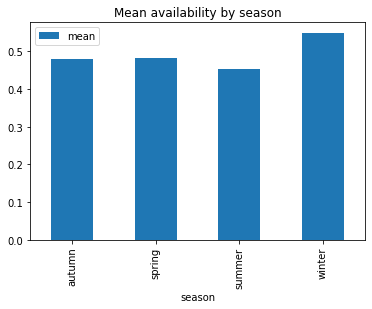

In [ ]:
# Summer seem to have the lowest availability which makes sense
boston_calendar_avail.plot(x='season', y='mean',kind="bar", title = 'Mean availability by season')

<AxesSubplot:title={'center':'Mean price by season'}, xlabel='season'>

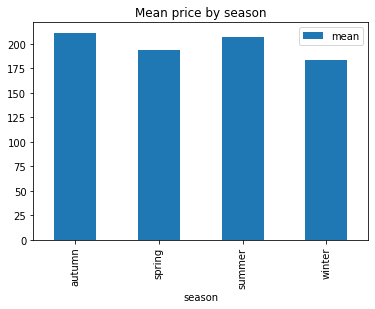

In [ ]:
# Unlike what was expected Autumn has the highest mean price and not summer
boston_price_season=boston_calendar_df.groupby('season').agg(['mean']).reset_index()
boston_price_season.plot(x='season', y='price',kind="bar", title = 'Mean price by season')

### Are super hosts less likely to get negative reviews than regular hosts?

In [ ]:
# Calculate review positive/negative rate per listing
boston_reviews_df['comments_senti_label_int'] = boston_reviews_df['comments_senti_label'].apply(lambda x: 1 if x=="POSITIVE" else 0)
boston_reviews_avg_review_sentiment = boston_reviews_df.groupby("listing_id")["comments_senti_label_int"].agg(["mean"]).reset_index()

In [ ]:
boston_reviews_avg_review_sentiment.head()

,listing_id,mean
0,3353,0.941176
1,5506,0.972222
2,6695,1.000000
3,6976,0.975610
4,8792,1.000000


In [ ]:
boston_reviews_avg_review_sentiment = boston_reviews_avg_review_sentiment.rename(columns={"mean": "sentiment_avg"})
bosting_listings_review_senti = pd.merge(boston_listings_df, boston_reviews_avg_review_sentiment, left_on="id", right_on="listing_id", how="left", sort=False)

In [ ]:
bosting_listings_review_senti_super_host_senti =  bosting_listings_review_senti.groupby("host_is_superhost")["sentiment_avg"].agg(["mean"]).reset_index()
bosting_listings_review_senti_super_host_senti.head()

,host_is_superhost,mean
0,f,0.889271
1,t,0.988113


<AxesSubplot:title={'center':'Average positive reviews per host type'}, xlabel='host_is_superhost'>

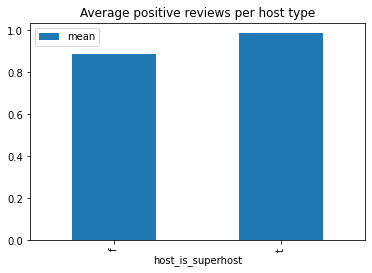

In [ ]:
# Super hosts are less likely to have reviews with negative sentiments vs regular hosts
bosting_listings_review_senti_super_host_senti.plot(x='host_is_superhost', y='mean',kind="bar", title = 'Average positive reviews per host type')

### Can we predict listing price? What are the main factors influencing a listing price?

In [ ]:
bosting_listings_review_senti['price'] = bosting_listings_review_senti['price'].str.replace('$','')
bosting_listings_review_senti['price'] = bosting_listings_review_senti['price'].str.replace(',','')
bosting_listings_review_senti['price'] = pd.to_numeric(bosting_listings_review_senti['price'])

In [ ]:
bosting_listings_review_senti['price'].describe()

count    3585.000000
mean      173.925802
std       148.331321
min        10.000000
25%        85.000000
50%       150.000000
75%       220.000000
max      4000.000000
Name: price, dtype: float64

In [ ]:
bosting_listings_review_senti.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,neighborhood_overview_senti_value,listing_id,sentiment_avg
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,moderate,f,f,1,NaN,POSITIVE,NaN,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,NaN,t,moderate,f,f,1,1.30,POSITIVE,3075044.0,0.944444
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,NaN,f,moderate,t,f,1,0.47,POSITIVE,6976.0,0.975610
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,NaN,f,moderate,f,f,1,1.00,POSITIVE,1436513.0,1.000000
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,NaN,f,flexible,f,f,1,2.25,POSITIVE,7651065.0,1.000000


In [ ]:
bosting_listings_review_senti.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

#### Converting variables from string to numeric by removing dolalr signs and commas. As ML algorithms can better understand numerical data

In [ ]:
bosting_listings_review_senti['host_response_rate'] = bosting_listings_review_senti['host_response_rate'].str.replace('%','')
bosting_listings_review_senti['host_response_rate'] = pd.to_numeric(bosting_listings_review_senti['host_response_rate'])

In [ ]:
bosting_listings_review_senti['host_acceptance_rate'] = bosting_listings_review_senti['host_acceptance_rate'].str.replace('%','')
bosting_listings_review_senti['host_acceptance_rate'] = pd.to_numeric(bosting_listings_review_senti['host_acceptance_rate'])

In [ ]:
bosting_listings_review_senti['neighborhood_overview_senti_value'].value_counts()

POSITIVE    2148
NEGATIVE      22
Name: neighborhood_overview_senti_value, dtype: int64

#### Hand picking the top candidates variable to use in the model first iteration
#### There is more advanced techniques to do feature selection that could be applied in future iterations

#### Using Pandas get_dummies function with dummy_na = True to 1-hot encode categorical variablesto be able to be used in ML

In [ ]:
X = bosting_listings_review_senti[['host_response_time', 'host_response_rate', 'host_acceptance_rate','host_is_superhost',
                               'neighbourhood_cleansed', 'host_identity_verified','property_type', 'room_type',
                               'accommodates', 'bathrooms', 'beds', 'bed_type', 'square_feet', 'number_of_reviews',
                              'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                              'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                              'review_scores_value', 'instant_bookable', 'cancellation_policy', 'reviews_per_month', 'neighborhood_overview_senti_value', 'sentiment_avg']]
print(X.shape)
X = pd.get_dummies(X, dummy_na=True)
print(X.shape)
y = bosting_listings_review_senti['price']

(3585, 26)
(3585, 88)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=123)

In [ ]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [ ]:
param = {'max_depth': 6, 'eta': 0.3, 'objective': 'reg:squarederror'}
param['nthread'] = 32
param['eval_metric'] = 'rmse'

In [ ]:
evallist = [(dtrain, 'train')]

#### Training a XGBoost model with almost default parameters.
#### XGBoost is chosen for it is ability to deal with missing data through learning a default path, scalability, feature importance and reliable performance in similar problems

In [ ]:
num_round = 300
bst = xgb.train(param, dtrain, num_round, evallist)

[0]	train-rmse:185.01393
[1]	train-rmse:153.97221
[2]	train-rmse:134.54086
[3]	train-rmse:119.57508
[4]	train-rmse:110.95979
[5]	train-rmse:105.75976
[6]	train-rmse:102.12614
[7]	train-rmse:97.01290
[8]	train-rmse:95.15301
[9]	train-rmse:93.45530
[10]	train-rmse:92.08857
[11]	train-rmse:86.63902
[12]	train-rmse:86.24725
[13]	train-rmse:85.01826
[14]	train-rmse:84.60593
[15]	train-rmse:84.21934
[16]	train-rmse:83.91897
[17]	train-rmse:83.40620
[18]	train-rmse:82.33285
[19]	train-rmse:81.29102
[20]	train-rmse:80.82272
[21]	train-rmse:80.46346
[22]	train-rmse:80.29414
[23]	train-rmse:80.01276
[24]	train-rmse:79.55309
[25]	train-rmse:77.02558
[26]	train-rmse:76.67838
[27]	train-rmse:76.28838
[28]	train-rmse:76.14771
[29]	train-rmse:75.92512
[30]	train-rmse:75.80630
[31]	train-rmse:73.27773
[32]	train-rmse:72.60247
[33]	train-rmse:72.34647
[34]	train-rmse:72.27479
[35]	train-rmse:71.86921
[36]	train-rmse:71.83295
[37]	train-rmse:71.38177
[38]	train-rmse:70.98111
[39]	train-rmse:70.43744
[40

#### Create test dataset and predict using trained model

In [ ]:
dtest = xgb.DMatrix(X_test)
y_pred = bst.predict(dtest)

In [ ]:
y_test

3257    118.0
2374    169.0
3525     55.0
569     285.0
2054    290.0
        ...  
3361     90.0
1426    169.0
498     100.0
3105    249.0
3499    130.0
Name: price, Length: 1184, dtype: float64

In [ ]:
y_pred

array([100.87505 , 210.51944 ,  45.006195, ...,  48.44925 , 187.62566 ,
        69.75477 ], dtype=float32)

#### Calculate perdormance metrics such MSE and RMSE

In [ ]:
#MSE
mean_squared_error(y_test, y_pred)

16046.416276821514

In [ ]:
#RMSE
mean_squared_error(y_test, y_pred, squared=False)

126.6744499763923

#### While there is room for improvement we can predict with price with decent accuracy
#### the number of reviews per month + host response rate seems to contribute heavily to the unit price
#### It is likely that more popular and expensive unit get more reivews per month
#### The higher the deman the higher the price (potentially)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

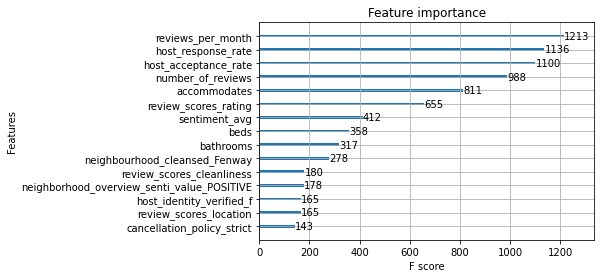

In [ ]:
xgb.plot_importance(bst, max_num_features = 15)

## Thank you